In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import ipywidgets        as widgets

from matplotlib.gridspec  import GridSpec
from matplotlib           import rcParams, rc
from mpl_toolkits.mplot3d import Axes3D

# Change the matplotlib default parameters
rcParams.update({'font.size':   12})
rcParams.update({'figure.dpi': 150})
rc('font', family='serif')
rc('text', usetex=True)

# Gaussian Processes

- _How to define probability distributions on a set of functions?_ 
- _How to incorporate prior knowledge about a function, e.g. some function values or values of its derivatives, into a guess (i.e. a prediction) for that function?_

In case you need to find a function given some function values this is often refered to as **regression**, and when derivatives are involved this sounds more like a **differential equation solver**. In fact, we are indeed interested in something in between.

## Predicting function values

Consider the set of functions $f: X \rightarrow Y$, that map each element $x \in X$ to an element $f(x) = y \in Y$.  Our goal will be to predict the function value $f(x)$ for a certain $x \in X$. We might have some idea about what the function values should be, e.g. suppose we can guess that the expectation (considering all possible functions $f$) for the function value at $x$ is $\mathbb{E}_{f}[f(x)] = \mu(x)$. Furthermore we might also have an idea about the error on this guess, e.g. suppose we can guess the expected quadratic difference between the true function value and its prediciton to be $\mathbb{E}_{f}[(f(x)-\mu(x))^{2}] = \sigma^{2}(x)$. One way to define a distribution of functions is to assume now that each function value $f(x)$ follows a normal distribution with mean $\mu(x)$ and variance $\sigma^{2}(x)$, i.e. $f(x) \sim \mathcal{N}(\mu(x), \sigma^{2}(x))$.

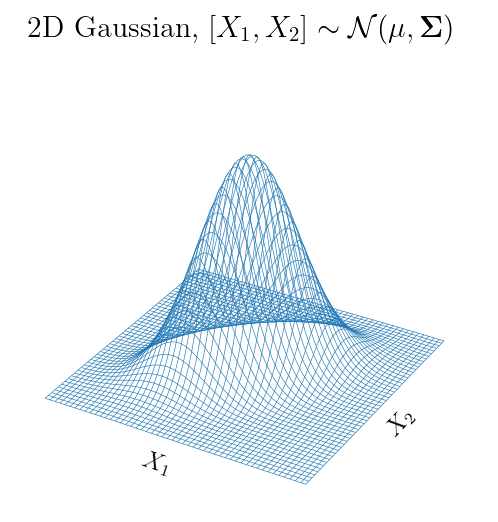

In [2]:
fig = plt.figure()

ax = fig.gca(projection='3d', frame_on=False)

X, Y = np.meshgrid(
    np.arange(-3, 3, 0.01),
    np.arange(-3, 3, 0.01) )
Z = np.exp(-(1*X**2 + Y**2-1.1*X*Y))

ax.plot_wireframe(X, Y, Z, linewidth=0.3)

ax.set_title('2D Gaussian, $[X_1, X_2] \sim \mathcal{N}(\mathbf{\mu}, \mathbf{\Sigma})$', pad=-13)
ax.set_xlabel('$X_{1}$', labelpad=-19)
ax.set_ylabel('$X_{2}$', labelpad=-20)
ax.dist = 8.5

ax.xaxis.pane.set_color('w')
ax.yaxis.pane.set_color('w')
ax.zaxis.pane.set_color('w')

ax.xaxis.line.set_color('w')
ax.yaxis.line.set_color('w')
ax.zaxis.line.set_color('w')

ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.zaxis.set_ticks([])

plt.show()

Probability distribution funtion for a $d$-dimensional Gaussian (or normal) distribution with mean vector $\mathbf{\mu}$ and covariance matrix $\mathbf{\Sigma}$.

\begin{equation}
p(\mathbf{x}) \ = \ \frac{1}{\sqrt{(2\pi)^{d} \det \mathbf{\Sigma}}} \ \exp\left( -\frac{1}{2} (\mathbf{x} - \mathbf{\mu})^{\text{T}} \ \mathbf{\Sigma}^{-1} \ (\mathbf{x} - \mathbf{\mu})  \right)
\end{equation}

When two variable $X_{1}$ and $X_{2}$ are distributed according to a 2-dimensional Gaussian distribution, we can write

\begin{equation}
\left[
\begin{matrix}
X_{1} \\
X_{2}
\end{matrix}
\right]
\sim
\mathcal{N}
\left( \mathbf{\mu} =
    \left[
    \begin{matrix}
    \mu_{1} \\
    \mu_{2}
    \end{matrix}
    \right], \
    \mathbf{\Sigma} =
    \left[
    \begin{matrix}
    k_{11} & k_{12} \\
    k_{21} & k_{22}
    \end{matrix}
    \right]
\right)
\end{equation}

In [3]:
N = 1000
x_min = 0.0
x_max = 2.0

x = np.linspace(x_min, x_max, N)

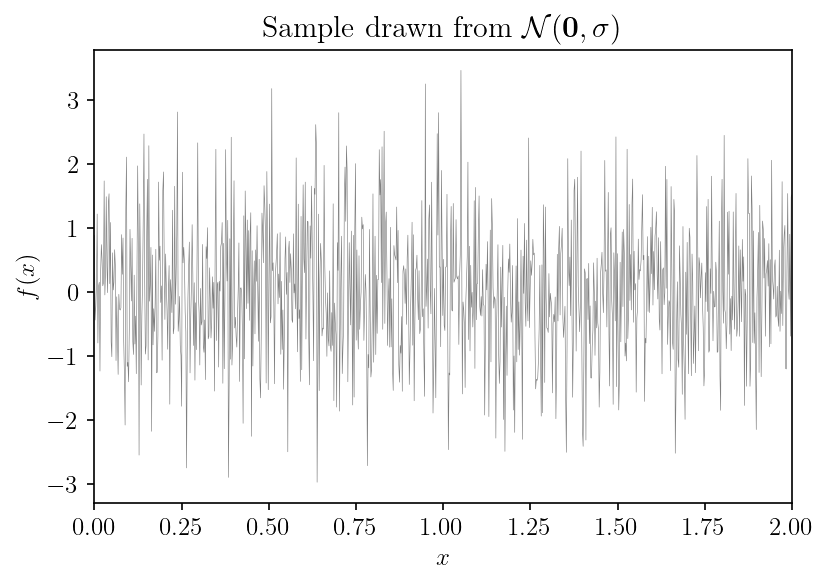

In [4]:
mean = 0.0
vari = 1.0

fi = np.random.normal(mean, vari, (N,1))

plt.title('Sample drawn from $\mathcal{N}(\mathbf{0},\mathbf{\sigma})$')
plt.plot(x, fi, c='gray', linewidth=0.3)
plt.xlim((x_min, x_max))
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()

Although this yields a perfectly well-defined distribution of functions, it should be noted that when sampling from this distribution the result will in general be a highly discontinuous function which is nowhere differentialble. Since this is undesirable in most cases, we need a way to enforce continuity on the set of considered functions. One way to do this is by enforcing correleations between the predicted function values, for instance by assuming the values to be distributed according to a multivariate Gaussian distribution $f(\textbf{x}) \sim \mathcal{N}(\mathbf{\mu}, \mathbf{\Sigma})$ such that the correlations are given by $\mathbf{\Sigma}_{ij} = k(x_{i},x_{j})$, where we introduced the correlation (or kernel) function $k$. A useful example is to take

\begin{equation}
\mathbf{\Sigma}_{ij} \ = \ k(x_{i}, x_{j}) \ = \ \alpha \exp \left( -\frac{\left(x_{i}-x_{j}\right)^{2}}{2 h^{2}} \right)
\end{equation}

In [5]:
alpha = 1.0


def kernel(x_i, x_j, h):
    X_i, X_j = np.meshgrid(x_i, x_j)
    return alpha**2 * np.exp(-0.5 * (X_i-X_j)**2 / h**2)


def plot_figure (h):

    mean = np.zeros(N)
    cov  = kernel(x, x, h)

    xf = np.concatenate((-np.flip(x),x))

    fig = plt.figure(constrained_layout=False, figsize=(5,6))
    gsp = fig.add_gridspec(5, 2, wspace=0.5, hspace=2.1)
    ax1 = fig.add_subplot(gsp[0:2, 0:1])
    ax2 = fig.add_subplot(gsp[0:2, 1:2])
    ax3 = fig.add_subplot(gsp[2:5, 0:2])

    ax1.set_title('Correlation function $k$', fontsize=12)
    ax1.plot(xf, kernel(0,xf, h))
    ax1.set_xlabel('$x_1-x_2$')
    ax1.set_ylabel('$k(x_1, x_2)$')
    ax1.set_ylim((-0.05, alpha**2+0.05))

    ax2.set_title('Correlation matrix $\mathbf{\Sigma}$', fontsize=12)
    ax2.imshow(cov, vmin=0.0, vmax=alpha**2)
    ax2.set_xlabel('index $i$')
    ax2.set_ylabel('index $j$')
    
    asp = np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
    ax1.set_aspect(asp)

    fs = np.random.multivariate_normal(mean, cov, 50).T

    ax3.set_title('Samples drawn from $\mathcal{N}(\mathbf{0},\mathbf{\Sigma})$', fontsize=12)
    ax3.plot(x, fs, c='gray', linewidth=0.3)
    ax3.set_xlim((x_min, x_max))
    ax3.set_ylim((-5*alpha**2, 5*alpha**2))
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$f(x)$')

    plt.show()

    
widgets.interact(plot_figure, h=(0.01, 1.0, 0.01))

interactive(children=(FloatSlider(value=0.5, description='h', max=1.0, min=0.01, step=0.01), Output()), _dom_c…

<function __main__.plot_figure(h)>

## Regression

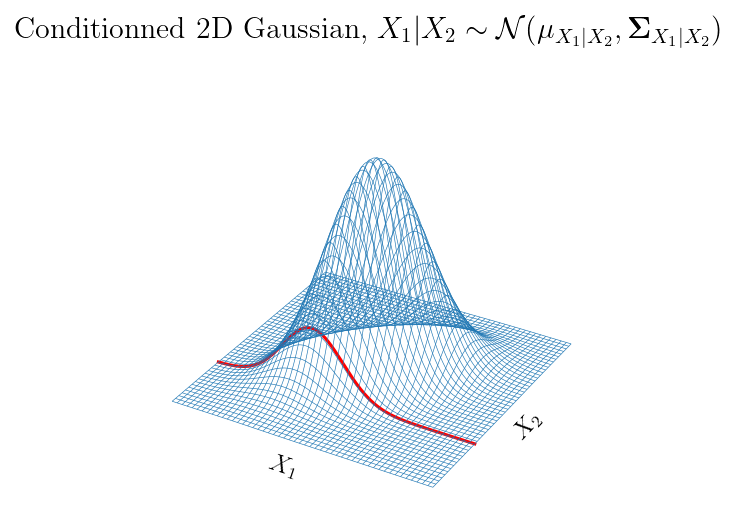

In [6]:
fig = plt.figure()

ax = fig.gca(projection='3d', frame_on=False)

X, Y = np.meshgrid(
    np.arange(-3, 3, 0.01),
    np.arange(-3, 3, 0.01) )

def p(X,Y):
    return np.exp(-(1*X**2 + Y**2-1.1*X*Y))

Z = p(X,Y)

ax.set_title(r'Conditionned 2D Gaussian, $X_1 | X_2 \sim \mathcal{N}\big(\mathbf{\mu}_{X_1 | X_2}, \mathbf{\Sigma}_{X_1 | X_2}\big)$', pad=-13)
ax.plot_wireframe(X, Y, Z, linewidth=0.3, zorder=1)

x1 =  np.arange(-3,3, 0.01)
y1 = -1.3*np.ones(len(x1))

z1 = p(x1,y1)

ax.plot(x1,y1,z1, c='red', linewidth=1.5, zorder=0)

ax.set_xlabel('$X_{1}$', labelpad=-19)
ax.set_ylabel('$X_{2}$', labelpad=-20)
ax.dist = 8.5

ax.xaxis.pane.set_color('w')
ax.yaxis.pane.set_color('w')
ax.zaxis.pane.set_color('w')

ax.xaxis.line.set_color('w')
ax.yaxis.line.set_color('w')
ax.zaxis.line.set_color('w')

ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.zaxis.set_ticks([])

plt.show()

Suppose now that we already know what the function values are for some points. How can we incorporate that information in our distribution over functions? From a statistical point of view, this can be done by **conditionning**: we want to know the distribution of functions **_given_** some function values. Since we assumed that the function values are distributed according to a multivariate Gaussian, this is relatively easy, since condittioning a Gaussian again yields a Gaussian. Say that we know the function values for $x \in A$ and we punt them al in a vector $\textbf{x}$, the joint distribution can then be split as 

\begin{equation}
\left[
\begin{matrix}
f(x) \\
f(\textbf{x})
\end{matrix}
\right]
\sim
\mathcal{N}
\left(
    \left[
    \begin{matrix}
    \mu(x) \\
    \mu(\textbf{x})
    \end{matrix}
    \right],
    \left[
    \begin{matrix}
    k(x, x)          & k(\textbf{x}, x         ) \\
    k(x, \textbf{x}) & k(\textbf{x}, \textbf{x})
    \end{matrix}
    \right]
\right)
\end{equation}

Assuming the values $f(\textbf{x})$ are known, conditionning distribution yields

\begin{equation}
f(x) \ | \
f(\textbf{x})
\sim
\mathcal{N}
\left(
    \mathbf{\mu   }_{x | \textbf{x}}, \
    \mathbf{\Sigma}_{x | \textbf{x}}
\right)
\end{equation}

in which

\begin{align}
\mathbf{\mu}_{x | \textbf{x}}
\ &= \ \mu(x) \ + \
k(x, \textbf{x}) \ k(\textbf{x}, \textbf{x})^{-1} \left(f(\textbf{x}) \ - \ \mathbf{\mu(\textbf{x})}\right) \\
\mathbf{\Sigma}_{x | \textbf{x}}
\ &= \
k(x, x) \ - \ k(x, \textbf{x}) \ k(\textbf{x}, \textbf{x})^{-1} k(\textbf{x}, x)
\end{align}

Note:
- $\mathbf{\Sigma}_{x | \textbf{x}}$ does only the depend on the correlation function $k$ and not on any of the function values $f(\textbf{x})$, hence the error can be computed without knowing the actual value;

Assuming $\mu(x) = 0$

\begin{align}
f(x)
\ &= \
\sum_{i} k(x, x_{i}) \ w_{i} \\
\varepsilon(x)
\ &= \
k(x, x) - \sum_{i}\sum_{j} k(x, x_{i}) \ k(x_{i}, x_{j})^{-1} \ k(x_{j}, x)
\end{align}

The weights $w_{i}$ are defined by

\begin{equation}
\left(
    \begin{matrix}
    k(x_{1}, x_{1}) & k(x_{1}, x_{2}) & \cdots &  k(x_{1}, x_{N}) \\
    k(x_{2}, x_{1}) & k(x_{2}, x_{2}) & \cdots &  k(x_{2}, x_{N}) \\
    \vdots          & \vdots          & \ddots & \vdots           \\
    k(x_{N}, x_{1}) & k(x_{N}, x_{2}) & \cdots &  k(x_{N}, x_{N})
    \end{matrix}
\right)
\left(
    \begin{matrix}
    w_{1}  \\
    w_{2}  \\
    \vdots \\
    w_{N}
    \end{matrix}
\right)
\ = \
\left(
    \begin{matrix}
    f(x_{1})  \\
    f(x_{2})  \\
    \vdots \\
    f(x_{N})
    \end{matrix}
\right)
\end{equation}

This can be interpreted as demanding that the proposed expantion of $f$ in terms of kernel functions $k$ holds exactly at the 

\begin{align}
f(x_{1})
\ &= \
\sum_{i} k(x_{1}, x_{i}) \ w_{i} \\
f(x_{2})
\ &= \
\sum_{i} k(x_{2}, x_{i}) \ w_{i} \\
& \, \, \vdots \\
f(x_{N})
\ &= \
\sum_{i} k(x_{N}, x_{i}) \ w_{i} \\
\end{align}

In [7]:
alpha = 1.0

def kernel(x_i, x_j, h):
    X_i, X_j = np.meshgrid(x_i, x_j)
    return alpha**2 * np.exp(-0.5 * (X_i-X_j)**2 / h**2)


def plot(h):
    y  = np.array([0.501])
    fy = np.array([1.0])

    mean = np.matmul(np.matmul(kernel(y,x,h), np.linalg.inv(kernel(y,y,h))), fy)
    cov  = kernel(x,x,h) - np.matmul(np.matmul(kernel(y,x,h), np.linalg.inv(kernel(y,y,h))), kernel(x,y,h))

    xf = np.concatenate((-np.flip(x),x))

    fig = plt.figure(constrained_layout=False, figsize=(5,6))
    gsp = fig.add_gridspec(5, 2, wspace=0.5, hspace=2.1)
    ax1 = fig.add_subplot(gsp[0:2, 0:1])
    ax2 = fig.add_subplot(gsp[0:2, 1:2])
    ax3 = fig.add_subplot(gsp[2:5, 0:2])

    ax1.set_title('Correlation function $k$', fontsize=12)
    ax1.plot(xf, kernel(0,xf, h))
    ax1.set_xlabel('$x_1-x_2$')
    ax1.set_ylabel('$k(x_1, x_2)$')
    ax1.set_ylim((-0.05, alpha**2+0.05))

    ax2.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
    ax2.imshow(cov, vmin=0.0, vmax=np.max(cov))
    ax2.set_xlabel('index $i$')
    ax2.set_ylabel('index $j$')
    
    asp = np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
    ax1.set_aspect(asp)

    fs = np.random.multivariate_normal(mean, cov, 50).T

    ax3.set_title('Samples drawn from $\mathcal{N}(\mathbf{\mu}_{x | \mathbf{x}},\mathbf{\Sigma}_{x | \mathbf{x}})$', fontsize=12)
    ax3.plot(x, fs, c='gray', linewidth=0.2)
    ax3.set_xlim((x_min, x_max))
    ax3.set_ylim((-4*alpha**2, 4*alpha**2))
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$f(x)$')
    ax3.plot(x, mean, linewidth=0.75)
    ax3.plot(x, mean+2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)
    ax3.plot(x, mean-2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)

    plt.show()
    
widgets.interact(plot, h=(0.01, 1.0, 0.01))

interactive(children=(FloatSlider(value=0.5, description='h', max=1.0, min=0.01, step=0.01), Output()), _dom_c…

<function __main__.plot(h)>

In [8]:
alpha = 1.0


def kernel(x_i, x_j, h):
    X_i, X_j = np.meshgrid(x_i, x_j)
    return alpha**2 * np.exp(-0.5 * (X_i-X_j)**2 / h**2)


def plot(h):
    y  = np.array([0.25,  0.50, 0.75])
    fy = np.array([1.25, -1.75, 0.25])

    mean = np.matmul(np.matmul(kernel(y,x,h), np.linalg.inv(kernel(y,y,h))), fy)
    cov  = kernel(x,x,h) - np.matmul(np.matmul(kernel(y,x,h), np.linalg.inv(kernel(y,y,h))), kernel(x,y,h))

    xf = np.concatenate((-np.flip(x),x))

    fig = plt.figure(constrained_layout=False, figsize=(5,6))
    gsp = fig.add_gridspec(5, 2, wspace=0.5, hspace=2.1)
    ax1 = fig.add_subplot(gsp[0:2, 0:1])
    ax2 = fig.add_subplot(gsp[0:2, 1:2])
    ax3 = fig.add_subplot(gsp[2:5, 0:2])

    ax1.set_title('Correlation function $k$', fontsize=12)
    ax1.plot(xf, kernel(0,xf, h))
    ax1.set_xlabel('$x_1-x_2$')
    ax1.set_ylabel('$k(x_1, x_2)$')
    ax1.set_ylim((-0.05, alpha**2+0.05))

    ax2.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
    ax2.imshow(cov, vmin=0.0, vmax=np.max(cov))
    ax2.set_xlabel('index $i$')
    ax2.set_ylabel('index $j$')
    
    asp = np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
    ax1.set_aspect(asp)

    fs = np.random.multivariate_normal(mean, cov, 50).T

    ax3.set_title('Samples drawn from $\mathcal{N}(\mathbf{\mu}_{x | \mathbf{x}},\mathbf{\Sigma}_{x | \mathbf{x}})$', fontsize=12)
    ax3.plot(x, fs, c='gray', linewidth=0.2)
    ax3.set_xlim((x_min, x_max))
#     ax3.set_ylim((-5*alpha**2, 5*alpha**2))
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$f(x)$')
    ax3.plot(x, mean, linewidth=0.75)
    ax3.plot(x, mean+2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)
    ax3.plot(x, mean-2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)

    plt.show()
    
widgets.interact(plot, h=(0.01, 1.0, 0.01))

interactive(children=(FloatSlider(value=0.5, description='h', max=1.0, min=0.01, step=0.01), Output()), _dom_c…

<function __main__.plot(h)>

## Conditionning on derivatives

In [9]:
def diff(x, y):
    # Compute derivative
    dy = np.diff(y)
    dx = np.diff(x)
    # Compute corresponding x
    x = 0.5*(x[:-1] + x[1:])
    # Return result
    return (x, dy/dx)

def diff2(x, y):
    x_d, y_d = diff(x, y)
    return diff(x_d, y_d)

\begin{equation}
\begin{split}
\mathbf{\mu}_{i}     \ &\equiv \ \mathbb{E}\big[ X_{i} \big] \\
\mathbf{\Sigma}_{ij} \ &\equiv \ \mathbb{E}\big[(X_{i} - \mathbf{\mu}_{i}) (X_{j} - \mathbf{\mu}_{j}) \big]
\end{split}
\end{equation}

\begin{equation}
\left[
\begin{matrix}
f(x) \\
f(\textbf{x}_{a}) \\
\partial f(\textbf{x}_{b})
\end{matrix}
\right]
\sim
\mathcal{N}
\left(
    \left[
    \begin{matrix}
    \mu(x) \\
    \mu(\textbf{x}_a) \\
    \partial\mu(\textbf{x}_b)
    \end{matrix}
    \right],
    \left[
    \begin{matrix}
    k(x, x)              & k(\textbf{x}_a, x               ) & \partial_{\mathbf{x}_{b}}k(\textbf{x}_b, x         ) \\
    k(x, \textbf{x}_{a}) & k(\textbf{x}_{a}, \textbf{x}_{a}) & \partial_{\mathbf{x}_{b}}k(\textbf{x}_b, \mathbf{x}_{a}         ) \\
    \partial_{\mathbf{x}_{b}}k(x, \textbf{x}_b)  & \partial_{\mathbf{x}_{b}}k(\mathbf{x}_{a}, \textbf{x}_b)  & \partial_{\mathbf{x}_{b}} \partial_{\mathbf{x}_{b}} k(\textbf{x}_b, \mathbf{x}_{b}         ) \\
    \end{matrix}
    \right]
\right)
\end{equation}

In [10]:
alpha = 1.0


def kernel(x, y, h):
    return alpha**2 * np.exp(-0.5 * (x-y)**2 / h**2)

def Lx_kernel(x, y, h):
    """
    First derivative of corr in variable x.
    (Equal to minus first derivative in variable y.)
    """
    return -(x-y) / h**2 * kernel(x, y, h)

def Ly_kernel(x, y, h):
    """
    First derivative of corr in variable x.
    (Equal to minus first derivative in variable y.)
    """
    return (x-y) / h**2 * kernel(x, y, h)

def L2_kernel(x, y, h):
    """
    First derivative of corr in variable x and y.
    """
    return (h**2 - (x-y)**2) / h**4 * kernel(x, y, h)

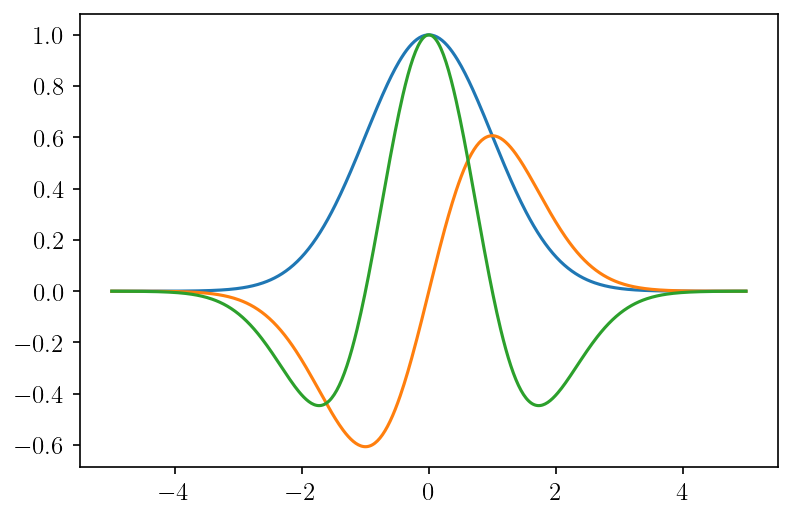

In [11]:
xx = np.linspace(-5, 5, 500)
h  = 1.0

plt.plot(xx,    kernel(0,xx,h))
plt.plot(xx, Lx_kernel(0,xx,h))
plt.plot(xx, L2_kernel(0,xx,h))

In [12]:
def corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return kernel(x, y, h).T

def Lx_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Lx_kernel(x, y, h).T

def Ly_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Ly_kernel(x, y, h).T

def L2_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return L2_kernel(x, y, h).T

In [13]:
def L_operator(x, y):
    return diff(x, y)

### Conditioning on a derivative

In [14]:
y_d  = np.array([ 0.5])
fy_d = np.array([10.0])


def plot(h):
    
    sigma_00 =    corr(x,   x,   h)
    sigma_10 = Ly_corr(x,   y_d, h)
    sigma_01 = Lx_corr(y_d, x,   h)
    sigma_11 = L2_corr(y_d, y_d, h)
    
    fy = np.block([fy_d])

    mean = np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), fy)
    cov  = sigma_00 - np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), sigma_01)

    xf = np.concatenate((-np.flip(x),x))

    fig = plt.figure(constrained_layout=False, figsize=(5,6))
    gsp = fig.add_gridspec(11, 2, wspace=0.5, hspace=2.1)
    ax1 = fig.add_subplot(gsp[0:2,  0:1])
    ax2 = fig.add_subplot(gsp[0:2,  1:2])
    ax3 = fig.add_subplot(gsp[2:5,  0:2])
    ax4 = fig.add_subplot(gsp[5:8,  0:2])
    ax5 = fig.add_subplot(gsp[8:11, 0:2])

    ax1.set_title('Correlation function $k$', fontsize=12)
    ax1.plot(xf, kernel(0,xf, h))
    ax1.set_xlabel('$x_1-x_2$')
    ax1.set_ylabel('$k(x_1, x_2)$')
    ax1.set_ylim((-0.05, alpha**2+0.05))

    ax2.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
    ax2.imshow(cov, vmin=0.0, vmax=np.max(cov))
    ax2.set_xlabel('index $i$')
    ax2.set_ylabel('index $j$')
    
    asp = np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
    ax1.set_aspect(asp)

    S = 25
    
    fs = np.random.multivariate_normal(mean, cov, S).T
    
    p_min = x_min
    p_max = x_max
    
    ax3.set_title('Samples drawn from $\mathcal{N}(\mathbf{\mu}_{x | \mathbf{x}},\mathbf{\Sigma}_{x | \mathbf{x}})$', fontsize=12)
    ax3.plot(x, fs, c='gray', linewidth=0.2)
    ax3.set_xlim((p_min, p_max))
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$f(x)$')
    ax3.plot(x, mean, linewidth=0.75)
    ax3.plot(x, mean+2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)
    ax3.plot(x, mean-2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)

    for s in range(S):
        xs, Ls = L_operator(x, fs[:,s])
        ax4.plot(xs, Ls, c='gray', linewidth=0.2)
        
    xs, Ls = L_operator(x, mean)
    ax4.plot(xs, Ls, linewidth=0.75)
    ax4.set_xlim((p_min, p_max))
    
    ax5.plot(x, np.diagonal(cov))
    ax5.set_xlim((p_min, p_max))
    
    plt.show()
    
widgets.interact(plot, h=(0.01, 1.0, 0.01))

interactive(children=(FloatSlider(value=0.5, description='h', max=1.0, min=0.01, step=0.01), Output()), _dom_c…

<function __main__.plot(h)>

### Conditioning on a derivative and function values

In [15]:
y_p  = np.array([0.0, 1.0])
fy_p = np.array([0.0, 1.0])

y_d  = np.array([  0.5])
fy_d = np.array([100.0])


def plot(h):
    
#     x = np.array([0.1])
    
    sigma_00 = corr(x, x, h)

    sigma_10 = np.block([   corr(x, y_p, h),
                         Ly_corr(x, y_d, h) ])
    
    sigma_01 = np.block([   corr(y_p, x, h).T,
                         Lx_corr(y_d, x, h).T ]).T

    print(   corr(y_p, y_p, h).shape)
    print(Lx_corr(y_d, y_p, h).T.shape)
    print(Ly_corr(y_p, y_d, h).shape)
    print(L2_corr(y_d, y_d, h).shape)
    
    sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
                         [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

#     print(sigma_00)
#     print(sigma_01)
#     print(sigma_10)
#     print(sigma_11)
    
    fy = np.block([fy_p, fy_d])

    mean =            np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), fy)
    cov  = sigma_00 - np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), sigma_01)

#     print(cov)
    
    xf = np.concatenate((-np.flip(x),x))

    fig = plt.figure(constrained_layout=False, figsize=(5,6))
    gsp = fig.add_gridspec(8, 2, wspace=0.5, hspace=2.1)
    ax1 = fig.add_subplot(gsp[0:2, 0:1])
    ax2 = fig.add_subplot(gsp[0:2, 1:2])
    ax3 = fig.add_subplot(gsp[2:5, 0:2])
    ax4 = fig.add_subplot(gsp[5:8, 0:2])

    ax1.set_title('Correlation function $k$', fontsize=12)
    ax1.plot(xf, kernel(0,xf, h))
    ax1.set_xlabel('$x_1-x_2$')
    ax1.set_ylabel('$k(x_1, x_2)$')
    ax1.set_ylim((-0.05, alpha**2+0.05))

    ax2.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
    ax2.imshow(cov, vmin=0.0, vmax=np.max(cov))
    ax2.set_xlabel('index $i$')
    ax2.set_ylabel('index $j$')
    
    asp = np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
    ax1.set_aspect(asp)

    S = 25
    
    fs = np.random.multivariate_normal(mean, cov, S).T
    
    ax3.set_title('Samples drawn from $\mathcal{N}(\mathbf{\mu}_{x | \mathbf{x}},\mathbf{\Sigma}_{x | \mathbf{x}})$', fontsize=12)
    ax3.plot(x, fs, c='gray', linewidth=0.2)
    ax3.set_xlim((x_min, x_max))
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$f(x)$')
    ax3.plot(x, mean, linewidth=0.75)
    ax3.plot(x, mean+2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)
    ax3.plot(x, mean-2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)

    for s in range(S):
        xs, Ls = L_operator(x, fs[:,s])
        ax4.plot(xs, Ls, c='gray', linewidth=0.2)
        
    xs, Ls = L_operator(x, mean)
    ax4.plot(xs, Ls, linewidth=0.75)
    
    plt.show()
    
widgets.interact(plot, h=(0.01, 1.0, 0.01))

interactive(children=(FloatSlider(value=0.5, description='h', max=1.0, min=0.01, step=0.01), Output()), _dom_c…

<function __main__.plot(h)>

In [16]:
y_p  = np.array([0.0, 2.0])
fy_p = np.array([0.0, 0.0])

y_d  = np.array([0, 1, 2])
fy_d = np.array([1, 1, 1])


def plot(h):
    
#     x = np.array([0.1])
    
    sigma_00 = corr(x, x, h)

    sigma_10 = np.block([   corr(x, y_p, h),
                         Ly_corr(x, y_d, h) ])
    
    sigma_01 = np.block([   corr(y_p, x, h).T,
                         Lx_corr(y_d, x, h).T ]).T

    print(   corr(y_p, y_p, h).shape)
    print(Lx_corr(y_d, y_p, h).T.shape)
    print(Ly_corr(y_p, y_d, h).shape)
    print(L2_corr(y_d, y_d, h).shape)
    
    sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
                         [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

#     print(sigma_00)
#     print(sigma_01)
#     print(sigma_10)
#     print(sigma_11)
    
    fy = np.block([fy_p, fy_d])

    mean =            np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), fy)
    cov  = sigma_00 - np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), sigma_01)

#     print(cov)
    
    xf = np.concatenate((-np.flip(x),x))

    fig = plt.figure(constrained_layout=False, figsize=(5,6))
    gsp = fig.add_gridspec(8, 2, wspace=0.5, hspace=2.1)
    ax1 = fig.add_subplot(gsp[0:2, 0:1])
    ax2 = fig.add_subplot(gsp[0:2, 1:2])
    ax3 = fig.add_subplot(gsp[2:5, 0:2])
    ax4 = fig.add_subplot(gsp[5:8, 0:2])

    ax1.set_title('Correlation function $k$', fontsize=12)
    ax1.plot(xf, kernel(0,xf, h))
    ax1.set_xlabel('$x_1-x_2$')
    ax1.set_ylabel('$k(x_1, x_2)$')
    ax1.set_ylim((-0.05, alpha**2+0.05))

    ax2.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
    ax2.imshow(cov, vmin=0.0, vmax=np.max(cov))
    ax2.set_xlabel('index $i$')
    ax2.set_ylabel('index $j$')
    
    asp = np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
    ax1.set_aspect(asp)

    S = 25
    
    fs = np.random.multivariate_normal(mean, cov, S).T
    
    ax3.set_title('Samples drawn from $\mathcal{N}(\mathbf{\mu}_{x | \mathbf{x}},\mathbf{\Sigma}_{x | \mathbf{x}})$', fontsize=12)
    ax3.plot(x, fs, c='gray', linewidth=0.2)
    ax3.set_xlim((x_min, x_max))
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$f(x)$')
    ax3.plot(x, mean, linewidth=0.75)
    ax3.plot(x, mean+2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)
    ax3.plot(x, mean-2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)

    for s in range(S):
        xs, Ls = L_operator(x, fs[:,s])
        ax4.plot(xs, Ls, c='gray', linewidth=0.2)
        
    xs, Ls = L_operator(x, mean)
    ax4.plot(xs, Ls, linewidth=0.75)
    
    plt.show()
    
widgets.interact(plot, h=(0.01, 1.0, 0.01))

interactive(children=(FloatSlider(value=0.5, description='h', max=1.0, min=0.01, step=0.01), Output()), _dom_c…

<function __main__.plot(h)>

In [17]:
# x = np.array([0,1,2])
h = 1.0

sigma_00 = corr(x, x, h)

sigma_10 = np.block([   corr(x, y_p, h),
                     Ly_corr(x, y_d, h) ])
    
sigma_01 = np.block([   corr(y_p, x, h).T,
                     Lx_corr(y_d, x, h).T ]).T

sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
                     [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

In [18]:
print(sigma_11)

[[ 1.          0.13533528 -0.         -0.60653066 -0.27067057]
 [ 0.13533528  1.          0.27067057  0.60653066 -0.        ]
 [ 0.          0.27067057  1.          0.         -0.40600585]
 [-0.60653066  0.60653066  0.          1.          0.        ]
 [-0.27067057  0.         -0.40600585  0.          1.        ]]


\begin{equation}
\left[
\begin{matrix}
f(x) \\
f(\textbf{x}_{b}) \\
\text{L} f(\cdot) |_{\mathbf{x}}
\end{matrix}
\right]
\sim
\mathcal{N}
\left(
    \left[
    \begin{matrix}
    \mu(x) \\
    \mu(\textbf{x}_b) \\
    \text{L} \mu(\cdot) | _{\mathbf{x}}
    \end{matrix}
    \right],
    \left[
    \begin{matrix}
    k(x, x)              & k(\textbf{x}_b, x               ) & \text{L} k(\cdot, x) |_{\mathbf{x}} \\
    k(x, \textbf{x}_{b}) & k(\textbf{x}_{b}, \textbf{x}_{b}) & \text{L} k(\cdot, \mathbf{x}_{b}) |_{\mathbf{x}} \\
    \text{L} k(x, \cdot ) |_{\mathbf{x}}  & \text{L} k(\mathbf{x}_{b}, \cdot ) |_{\mathbf{x}}  & \text{L}^{2} k(\cdot, \cdot ) |_{\mathbf{x}, \mathbf{x}}
    \end{matrix}
    \right]
\right)
\end{equation}

\begin{equation}
    \left(
    \begin{matrix}
    k(\textbf{x}_{b}, \textbf{x}_{b}) & \text{L} k(\cdot, \mathbf{x}_{b}) |_{\mathbf{x}} \\
    \text{L} k(\mathbf{x}_{b}, \cdot ) |_{\mathbf{x}}  & \text{L}^{2} k(\cdot, \cdot ) |_{\mathbf{x}, \mathbf{x}}
    \end{matrix}
    \right)
    \left(
    \begin{matrix}
    \mathbf{w}_{b} \\
    \mathbf{w}
    \end{matrix}
    \right)
    \ = \
    \left(
    \begin{matrix}
    f(\textbf{x}_{b}) \\
    \text{L} f(\cdot) |_{\mathbf{x}}
    \end{matrix}
    \right)
\end{equation}

\begin{equation}
f(x)
\ = \
\sum_{i} k(x, x^{i}_{b}) \ w^{i}_{b} \ + \ \sum_{j} \text{L} k(x, \cdot ) |_{x^{j}} \ w^{j}
\end{equation}

\begin{equation}
\text{L}f(\cdot) |_{x}
\ = \
\sum_{i} \text{L} k(\cdot, x^{i}_{b}) |_{x} \ w^{i}_{b} \ + \ \sum_{j} \text{L}^{2} k(\cdot, \cdot ) |_{x, x^{j}} \ w^{j}
\end{equation}

\begin{equation}
\left(\frac{\text{d}}{\text{d}x} + \chi(x) \right) I(x) \ = \ \eta(x)
\end{equation}

In [23]:
def eta(x):
    return 1.0

def chi(x):
    return 1.0

In [24]:
alpha = 1.0

def kernel(x, y, h):
    return alpha**2 * np.exp(-0.5 * (x-y)**2 / h**2)

def Lx_kernel(x, y, h):
    return (h**2 - (x-y)/chi(x)) / h**2 * kernel(x, y, h)

def Ly_kernel(x, y, h):
    return (h**2 + (x-y)/chi(y)) / h**2 * kernel(x, y, h)

def L2_kernel(x, y, h):
    return (h**4 - (chi(x)-chi(y))*(x-y)*h**2 + h**2 - (x-y)**2) / h**4 /(chi(x)*chi(y)) * kernel(x, y, h)

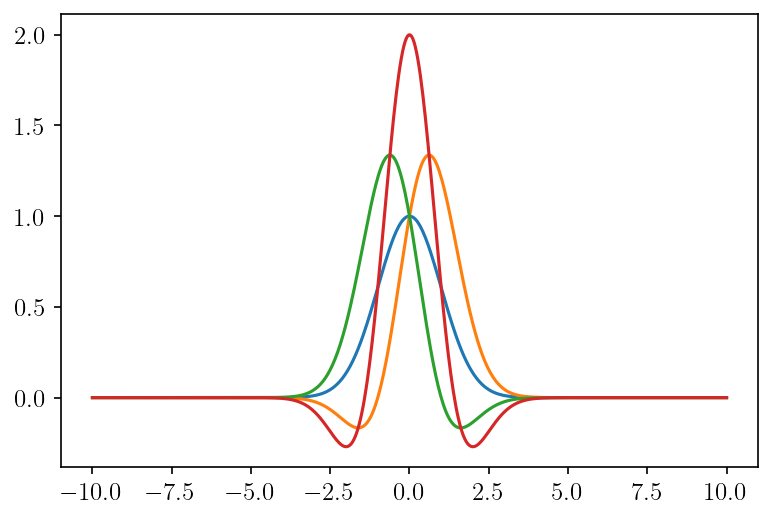

In [25]:
xx = np.linspace(-10, 10, 500)
h  = 1.0

plt.plot(xx,    kernel(0,xx,h))
plt.plot(xx, Lx_kernel(0,xx,h))
plt.plot(xx, Ly_kernel(0,xx,h))
plt.plot(xx, L2_kernel(0,xx,h))

In [26]:
def corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return kernel(x, y, h).T

def Lx_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Lx_kernel(x, y, h).T

def Ly_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Ly_kernel(x, y, h).T

def L2_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return L2_kernel(x, y, h).T

In [27]:
def diff(x, y):
    # Compute derivative
    dy = np.diff(y)
    dx = np.diff(x)
    # Compute corresponding x
    x = 0.5*(x[:-1] + x[1:])
    # Return result
    return (x, dy/dx)

def L_operator(x, y):
    x_d, y_d = diff(x, y)
    y_y = 0.5*(y[:-1] + y[1:])
    return (x_d, y_y + y_d/chi(x_d))

In [38]:
y_p  = np.array([0.0])
fy_p = np.array([1.0])

y_d  = np.array([0.0, 1.0, 2.0, 3.0, 4.0])
fy_d = np.array([eta(d) for d in y_d])


def plot(h):
    
#     x = np.array([0.1])
    
    sigma_00 = corr(x, x, h)

    sigma_10 = np.block([   corr(x, y_p, h),
                         Ly_corr(x, y_d, h) ])
    
    sigma_01 = np.block([   corr(y_p, x, h).T,
                         Lx_corr(y_d, x, h).T ]).T

    print(   corr(y_p, y_p, h).shape)
    print(Lx_corr(y_d, y_p, h).T.shape)
    print(Ly_corr(y_p, y_d, h).shape)
    print(L2_corr(y_d, y_d, h).shape)
    
    sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
                         [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

#     print(sigma_00)
#     print(sigma_01)
#     print(sigma_10)
#     print(sigma_11)
    
    fy = np.block([fy_p, fy_d])

    mean =            np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), fy)
    cov  = sigma_00 - np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), sigma_01)

#     print(cov)
    
    xf = np.concatenate((-np.flip(x),x))

    fig = plt.figure(constrained_layout=False, figsize=(5,6))
    gsp = fig.add_gridspec(8, 2, wspace=0.5, hspace=2.1)
    ax1 = fig.add_subplot(gsp[0:2, 0:1])
    ax2 = fig.add_subplot(gsp[0:2, 1:2])
    ax3 = fig.add_subplot(gsp[2:5, 0:2])
    ax4 = fig.add_subplot(gsp[5:8, 0:2])

    ax1.set_title('Correlation function $k$', fontsize=12)
    ax1.plot(xf, kernel(0,xf, h))
    ax1.set_xlabel('$x_1-x_2$')
    ax1.set_ylabel('$k(x_1, x_2)$')
    ax1.set_ylim((-0.05, alpha**2+0.05))

    ax2.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
    ax2.imshow(cov, vmin=0.0, vmax=np.max(cov))
    ax2.set_xlabel('index $i$')
    ax2.set_ylabel('index $j$')
    
    asp = np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
    ax1.set_aspect(asp)

    S = 25
    
    fs = np.random.multivariate_normal(mean, cov, S).T
    
    ax3.set_title('Samples drawn from $\mathcal{N}(\mathbf{\mu}_{x | \mathbf{x}},\mathbf{\Sigma}_{x | \mathbf{x}})$', fontsize=12)
    ax3.plot(x, fs, c='gray', linewidth=0.2)
    ax3.set_xlim((x_min, x_max))
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$f(x)$')
    ax3.plot(x, mean, linewidth=0.75)
    ax3.plot(x, mean+2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)
    ax3.plot(x, mean-2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)

    for s in range(S):
        xs, Ls = L_operator(x, fs[:,s])
        ax4.plot(xs, Ls, c='gray', linewidth=0.2)
        
    xs, Ls = L_operator(x, mean)
    ax4.plot(xs, Ls, linewidth=0.75)
    ax4.set_xlim((x_min, x_max))    

    plt.show()
    
widgets.interact(plot, h=(0.01, 1.0, 0.01))

interactive(children=(FloatSlider(value=0.5, description='h', max=1.0, min=0.01, step=0.01), Output()), _dom_c…

<function __main__.plot(h)>

In [39]:
h = 4.5
x = np.array([0, 1, 2, 3, 4])

sigma_00 = corr(x, x, h)

sigma_10 = np.block([   corr(x, y_p, h),
                     Ly_corr(x, y_d, h) ])
    
sigma_01 = np.block([   corr(y_p, x, h).T,
                     Lx_corr(y_d, x, h).T ]).T

sigma_11 = np.block([[   corr(y_p, y_p, h),   Lx_corr(y_d, y_p, h).T],
                     [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

fy = np.block([fy_p, fy_d])

In [40]:
print(sigma_11)

[[1.         1.         0.92743266 0.81647814 0.68210964 0.54057407]
 [1.         1.04938272 1.02141012 0.94185648 0.82270551 0.68062023]
 [0.92743266 1.02141012 1.04938272 1.02141012 0.94185648 0.82270551]
 [0.81647814 0.94185648 1.02141012 1.04938272 1.02141012 0.94185648]
 [0.68210964 0.82270551 0.94185648 1.02141012 1.04938272 1.02141012]
 [0.54057407 0.68062023 0.82270551 0.94185648 1.02141012 1.04938272]]


In [41]:
print(sigma_10)

[[1.         1.         0.92743266 0.81647814 0.68210964 0.54057407]
 [0.97561098 1.0237893  1.         0.92743266 0.81647814 0.68210964]
 [0.90595519 0.99543225 1.0237893  1.         0.92743266 0.81647814]
 [0.8007374  0.91936517 0.99543225 1.0237893  1.         0.92743266]
 [0.67363846 0.80670284 0.91936517 0.99543225 1.0237893  1.        ]]


In [42]:
print(sigma_01)

[[1.         0.97561098 0.90595519 0.8007374  0.67363846]
 [1.         1.0237893  0.99543225 0.91936517 0.80670284]
 [0.92743266 1.         1.0237893  0.99543225 0.91936517]
 [0.81647814 0.92743266 1.         1.0237893  0.99543225]
 [0.68210964 0.81647814 0.92743266 1.         1.0237893 ]
 [0.54057407 0.68210964 0.81647814 0.92743266 1.        ]]


In [33]:
fy

array([1., 1., 1., 1.])

In [71]:
mean = np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), fy)
mean

array([1.75708732e-16, 1.01114783e+00, 4.49689762e-01, 1.63446469e+00,
       8.63198402e-15])

In [22]:
y_p  = np.array([0.0])
fy_p = np.array([1.0])

y_d  = np.linspace(0.0, 2.0, num=5)
fy_d = np.array([eta(d) for d in y_d])


def plot(h):
    
#     x = np.array([0.1])
    
    sigma_00 = corr(x, x, h)

    sigma_10 = np.block([   corr(x, y_p, h),
                         Ly_corr(x, y_d, h) ])
    
    sigma_01 = np.block([   corr(y_p, x, h).T,
                         Lx_corr(y_d, x, h).T ]).T

#     print(   corr(y_p, y_p, h).shape)
#     print(Lx_corr(y_d, y_p, h).T.shape)
#     print(Ly_corr(y_p, y_d, h).shape)
#     print(L2_corr(y_d, y_d, h).shape)
    
    sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
                         [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

#     print(sigma_00)
#     print(sigma_01)
    print('sigma_10 ', sigma_10.shape)
    print('sigma_11 ', sigma_11.shape)
    
    fy = np.block([fy_p, fy_d])

    print(fy_p.shape)
    print(fy_d.shape)
    print(fy.shape)
    
    mean =            np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), fy)
    cov  = sigma_00 - np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), sigma_01)

#     print(cov)
    
    xf = np.concatenate((-np.flip(x),x))

    fig = plt.figure(constrained_layout=False, figsize=(5,6))
    gsp = fig.add_gridspec(8, 2, wspace=0.5, hspace=2.1)
    ax1 = fig.add_subplot(gsp[0:2, 0:1])
    ax2 = fig.add_subplot(gsp[0:2, 1:2])
    ax3 = fig.add_subplot(gsp[2:5, 0:2])
    ax4 = fig.add_subplot(gsp[5:8, 0:2])

    ax1.set_title('Correlation function $k$', fontsize=12)
    ax1.plot(xf, kernel(0,xf, h))
    ax1.set_xlabel('$x_1-x_2$')
    ax1.set_ylabel('$k(x_1, x_2)$')
    ax1.set_ylim((-0.05, alpha**2+0.05))

    ax2.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
    ax2.imshow(cov, vmin=0.0, vmax=np.max(cov))
    ax2.set_xlabel('index $i$')
    ax2.set_ylabel('index $j$')
    
    asp = np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
    ax1.set_aspect(asp)

    S = 25
    
    fs = np.random.multivariate_normal(mean, cov, S).T
    
    ax3.set_title('Samples drawn from $\mathcal{N}(\mathbf{\mu}_{x | \mathbf{x}},\mathbf{\Sigma}_{x | \mathbf{x}})$', fontsize=12)
    ax3.plot(x, fs, c='gray', linewidth=0.2)
    ax3.set_xlim((x_min, x_max))
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$f(x)$')
    ax3.plot(x, mean, linewidth=0.75, marker='x')
    ax3.plot(x, mean+2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)
    ax3.plot(x, mean-2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)

    ax3.plot(x, np.exp(-x), linewidth=0.75)
    
    for s in range(S):
        xs, Ls = L_operator(x, fs[:,s])
        ax4.plot(xs, Ls, c='gray', linewidth=0.2)
        
    xs, Ls = L_operator(x, mean)
    ax4.plot(xs, Ls, linewidth=0.75)
    ax4.set_xlim((x_min, x_max))
    
    plt.show()
    
widgets.interact(plot, h=(0.01, 1.0, 0.01))

interactive(children=(FloatSlider(value=0.5, description='h', max=1.0, min=0.01, step=0.01), Output()), _dom_c…

<function __main__.plot(h)>

In [91]:
h     = 0.5
alpha = 1.0


def corr(x, y, h):
    (x, y) = np.meshgrid(x, y)
    result = alpha**2 * np.exp(-0.5 * (x-y)**2 / h**2)
    return result.T

def Lx_corr(x, y, h):
    (x, y) = np.meshgrid(x, y)
    result = (chi(x)*h**2 - (x-y)) / h**2 * kernel(x, y, h)
    return result.T

def Ly_corr(x, y, h):
    (x, y) = np.meshgrid(x, y)
    result = (chi(y)*h**2 + (x-y)) / h**2 * kernel(x, y, h)
    return result.T

def L2_corr(x, y, h):
    (x, y) = np.meshgrid(x, y)
    result = (chi(x)*chi(y)*h**4 - (chi(x)-chi(y))*(x-y)*h**2 + h**2 - (x-y)**2) / h**4 * kernel(x, y, h)
    return result.T


sigma_00 = corr(x, x, h)

sigma_10 = np.block([corr(x,   y_p, h),   Ly_corr(x,   y_d, h)  ])
sigma_01 = np.block([corr(y_p, x,   h).T, Lx_corr(y_d, x,   h).T]).T

sigma_11 = np.block([[   corr(y_p, y_p, h),   Lx_corr(y_d, y_p, h).T],
                     [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

fy = np.block([fy_p, fy_d])
    
mean = np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), fy)

In [92]:
np.mean(cov)

0.001871711588423334

In [93]:
np.max(cov - cov.T)

8.881784197001252e-16

\begin{equation}
\left(1 - \frac{\text{d}^{2}}{\text{d}\tau^{2}} \right) u(\tau) \ = \ S(\tau)
\end{equation}

\begin{equation}
\left[
\begin{matrix}
    \text{d}_{x} & \chi(x)      \\
    \chi(x)      & \text{d}_{x} \\
\end{matrix}
\right]
\left[
\begin{matrix}
    u(x) \\
    v(x)
\end{matrix}
\right]
\ = \
\left[
\begin{matrix}
    0 \\
    \eta(x)
\end{matrix}
\right]
\end{equation}

\begin{equation}
\left(\chi(x) - \frac{\text{d}}{\text{d}x} \right) u(x) \ = \ \eta(x)
\end{equation}

# Beyond Gaussian Processes

## Student-$t$ processes
- [Tracy & Wolpert](http://mcubed.mit.edu/files/public/RT1/2018_Tracey_Wolpert_studenttaiaa.pdf)
- [Shah, Wilson, & Ghahramani](https://www.cs.cmu.edu/~andrewgw/tprocess.pdf)

# References

[Rasmussen & Williams (2006), Gaussian processes for Machine Learning.](http://www.gaussianprocess.org/gpml/)

# Tests
---

In [23]:
alpha = 1.0
h     = 1.0

def kernel(x, y, h):
    return alpha**2 * np.exp(-0.5 * (x-y)**2 / h**2)

def Lx_kernel(x, y, h):
    return (h**2 - (x-y)) / h**2 * kernel(x, y, h)

def Ly_kernel(x, y, h):
    return (h**2 + (x-y)) / h**2 * kernel(x, y, h)

def L2_kernel(x, y, h):
    return (h**4 + h**2 - (x-y)**2) / h**4 * kernel(x, y, h)

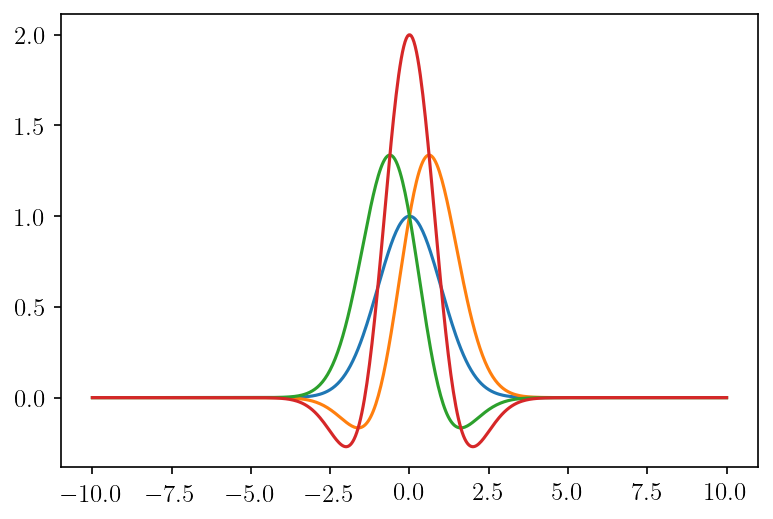

In [24]:
xx = np.linspace(-10, 10, 500)

plt.plot(xx,    kernel(0,xx,h))
plt.plot(xx, Lx_kernel(0,xx,h))
plt.plot(xx, Ly_kernel(0,xx,h))
plt.plot(xx, L2_kernel(0,xx,h))

In [25]:
def corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return kernel(x, y, h).T

def Lx_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Lx_kernel(x, y, h).T

def Ly_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Ly_kernel(x, y, h).T

def L2_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return L2_kernel(x, y, h).T

In [30]:
def diff(x, y):
    # Compute derivative
    dy = np.diff(y)
    dx = np.diff(x)
    # Compute corresponding x
    x = 0.5*(x[:-1] + x[1:])
    # Return result
    return (x, dy/dx)

def L_operator(x, y):
    x_d, y_d = diff(x, y)
    y_y = 0.5*(y[:-1] + y[1:])
    return (x_d, y_y + y_d)

### Conditioning on a derivative

In [32]:
y_d  = np.array([ 1.0])
fy_d = np.array([10.0])


def plot(h):
    
    sigma_00 =    corr(x,   x,   h)
    sigma_10 = Ly_corr(x,   y_d, h)
    sigma_01 = Lx_corr(y_d, x,   h)
    sigma_11 = L2_corr(y_d, y_d, h)
    
    fy = np.block(fy_d)

    mean =            np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), fy_d)
    cov  = sigma_00 - np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), sigma_01)

    
#     print(fy)
#     print(sigma_01)
    
    xf = np.concatenate((-np.flip(x),x))

    fig = plt.figure(constrained_layout=False, figsize=(5,6))
    gsp = fig.add_gridspec(8, 2, wspace=0.5, hspace=2.1)
    ax1 = fig.add_subplot(gsp[0:2, 0:1])
    ax2 = fig.add_subplot(gsp[0:2, 1:2])
    ax3 = fig.add_subplot(gsp[2:5, 0:2])
    ax4 = fig.add_subplot(gsp[5:8, 0:2])

    ax1.set_title('Correlation function $k$', fontsize=12)
    ax1.plot(xf, kernel(0,xf, h))
    ax1.set_xlabel('$x_1-x_2$')
    ax1.set_ylabel('$k(x_1, x_2)$')
    ax1.set_ylim((-0.05, alpha**2+0.05))

    ax2.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
    ax2.imshow(cov, vmin=0.0, vmax=np.max(cov))
    ax2.set_xlabel('index $i$')
    ax2.set_ylabel('index $j$')
    
    asp = np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
    ax1.set_aspect(asp)

    S = 100
    
    def mu(x):
        return Ly_corr(x, y_d[0], h) / L2_corr(y_d[0], y_d[0], h) * fy_d[0]
    
    def Lx_mu(x):
        return L2_corr(x, y_d[0], h) / L2_corr(y_d[0], y_d[0], h) * fy_d[0]
    
    fs = np.random.multivariate_normal(mean, cov, S).T
    
    ax3.set_title('Samples drawn from $\mathcal{N}(\mathbf{\mu}_{x | \mathbf{x}},\mathbf{\Sigma}_{x | \mathbf{x}})$', fontsize=12)
    ax3.plot(x, fs, c='gray', linewidth=0.2)
    ax3.set_xlim((x_min, x_max))
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$f(x)$')
    ax3.plot(x, mean, linewidth=0.75)
    ax3.plot(x, mu(x), linewidth=0.75, linestyle='dotted')
    ax3.plot(x, mean+2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)
    ax3.plot(x, mean-2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)

    for s in range(S):
        xs, Ls = L_operator(x, fs[:,s])
        ax4.plot(xs, Ls, c='gray', linewidth=0.2)
        
    xs, Ls = L_operator(x, mean)
    ax4.plot(xs, Ls, linewidth=0.75)
    ax4.set_xlim((x_min, x_max))
#     ax4.set_xlim((0.99, 1.01))
    ax4.plot(x,  fy_d[0]*np.ones(x.shape), linewidth=0.75)
    
    ax4.plot(x, Lx_mu(x), linewidth=0.75)
    
    plt.show()
    
widgets.interact(plot, h=(0.01, 2.0, 0.01))

interactive(children=(FloatSlider(value=1.0, description='h', max=2.0, min=0.01, step=0.01), Output()), _dom_c…

<function __main__.plot(h)>

In [59]:
alpha = 1.0
h     = 1.0

def kernel(x, y, h):
    d = x-y
    result = alpha*(1+3.0*np.abs(d))*(1-np.abs(d))**3
    result[np.abs(d)>1.0] = 0.0
    return result

def Lx_kernel(x, y, h):
    d = x-y
    result = -12.0*alpha*d*(1-np.abs(d))**2
    result[np.abs(d)>1.0] = 0.0
    return result

def Ly_kernel(x, y, h):
    d = x-y
    result =  12.0*alpha*d*(1-np.abs(d))**2
    result[np.abs(d)>1.0] = 0.0
    return result

def L2_kernel(x, y, h):
    d = x-y
    result =  12.0*alpha*(1-3.0*np.abs(d))*(1-np.abs(d))
    result[np.abs(d)>1.0] = 0.0
    return result

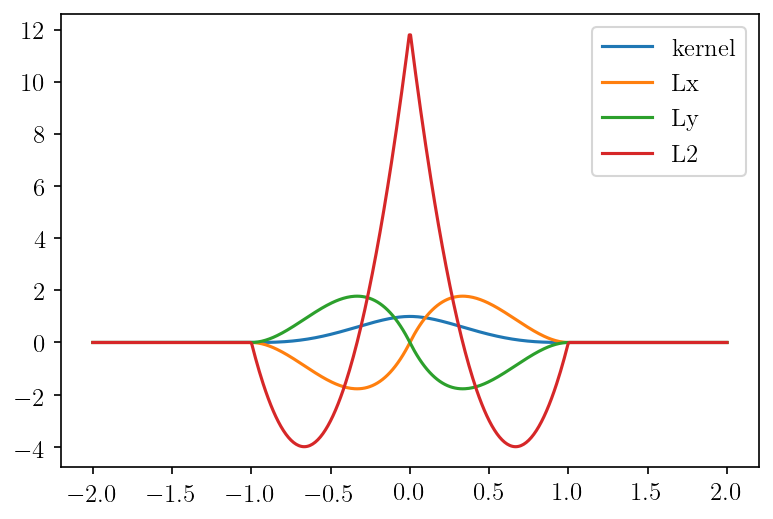

In [60]:
xx = np.linspace(-2, 2, 500)

plt.plot(xx,    kernel(0,xx,h), label='kernel')
plt.plot(xx, Lx_kernel(0,xx,h), label='Lx')
plt.plot(xx, Ly_kernel(0,xx,h), label='Ly')
plt.plot(xx, L2_kernel(0,xx,h), label='L2')
plt.legend()